## elevation cdfs and pattern repeatability visualization


In [16]:
# import datetime
# import os
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
from scipy.ndimage import gaussian_filter1d

# import gc

## plotting ## 
# import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
import matplotlib.transforms as mtransforms
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False
# from matplotlib import colors
## 

## custom dirs and functions
from dirs import wrfdir, basedir, coorddir, snoteldir
from myutils import wrfread, relativize_snow_values

## aesthetics
plt.style.use('style.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'


In [2]:

## make a nice snotel dataset
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat))
snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]



world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{basedir}data/huc2.shp')

coords = xr.open_dataset(f'{coorddir}wrfinput_d02')
states = gpd.read_file(f'{basedir}data/cb_2018_us_state_5m.shp')

coordslist = {}
for d in range(1,5):
    domain = f'd0{d}'
    coord = xr.open_dataset(f'{coorddir}wrfinput_{domain}')
    coordslist[domain] = coord
    

/tmp/ipykernel_1515607/181761217.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [3]:
sweMax = xr.open_dataset(f'{basedir}data/tmp/snowMax.nc').compute().rename({'__xarray_dataarray_variable__': 'swe'})
coordinate_pairs = xr.open_dataset(f'{basedir}/data/site_indices_snow_d02_ALL.nc')
huc2masks = xr.open_dataset(f'{basedir}/data/huc2_d02_masks.nc')

ii = coordinate_pairs['ii_dim'].values.flatten()
jj = coordinate_pairs['jj_dim'].values.flatten()
ii_dim = list(coordinate_pairs['ii_dim'].values)
jj_dim = list(coordinate_pairs['jj_dim'].values)
datas = []
for idx in range(703):
    data = sweMax['swe'][:,:,jj[idx], ii[idx]]
    datas.append(data)
snotel_sweMax= xr.concat(datas, dim = 'site')
snotelswe2 = np.load(f'{basedir}/data/snoteldata_aug22.npy', allow_pickle = True)

In [4]:
## load data
domain = 'd02'
coords = coordslist[domain]
lon_wrf = coords['XLONG'][0]
lat_wrf = coords['XLAT'][0]
elev_wrf = coords['HGT'][0]
lat_array = lat_wrf.data
lon_array = lon_wrf.data


subregions = ["SW","SCR","NCR","PNW","ALL"]
bound_arrays = [[35., 42., -121., -114.],
               [35., 42., -114., -105.],
               [42., 49., -117., -107.],
               [42., 49., -125., -117.],
               [35,49,-125,-105]]
start_dates = [[1980,9,1],[2030,9,1],[2070,9,1]]
end_dates = [[2010,9,1],[2060,9,1],[2100,9,1]]

In [5]:
## 
bns = [9,11,12,13,15,18]
subrnames = ['Upper Colorado',
             'Great Basin',
             'California',
             'Lower Colorado',
             'Pacific Northwest',
             'Missouri']
for bn in [9,11,12,13,15,18]:
    tmp = huc2.loc[bn:bn]
    print(tmp.name)

subrnames2 = ['Pacific Northwest',
              'California',
              'Great Basin',
              'Missouri',
              'Upper Colorado',
             ]

yearcolors =  ["#332288", '#117733', '#AA4499']


9    Upper Colorado Region
Name: name, dtype: object
11    Great Basin Region
Name: name, dtype: object
12    California Region
Name: name, dtype: object
13    Lower Colorado Region
Name: name, dtype: object
15    Pacific Northwest Region
Name: name, dtype: object
18    Missouri Region
Name: name, dtype: object


In [6]:
## by huc2
# Define the latitude and longitude boundary
min_lon = -135
max_lon = -105
min_lat = 22
max_lat = 45

# Select the parts of the GeoDataFrame within the specified boundary
mybasins = huc2.cx[min_lon:max_lon, min_lat:max_lat]

subregions = [val.split(' Region')[0] for val in mybasins.name]
regionmasks = huc2masks 

snow_by_elev_bin = {}
area_by_elev_bin = {}
for subregion in subregions:
    snow_by_elev_bin[subregion] = {}
    area_by_elev_bin[subregion] = []
    for gcm in range(9):
        snow_by_elev_bin[subregion][gcm] = []
    
    
elevation_min = elev_wrf.min()
elevation_max = elev_wrf.max()
elevation_step = 50
elevation_data= elev_wrf.data
elevation_bins = np.arange(elevation_min, elevation_max + elevation_step, elevation_step)

## elevation mask
mask = np.logical_and(elevation_data >= elevation_bins[:-1, np.newaxis, np.newaxis], elevation_data < elevation_bins[1:, np.newaxis, np.newaxis])

for i in range(12):
    y1 = 1980 + (10 * i)
    # Select the subset of the dataset within the day range
    subset = sweMax.sel(year=slice(y1, y1+10)).sum(dim = 'year')

    for j,idx in enumerate(bns):
        regmask = huc2masks.where(huc2masks['basin'] == idx, drop=True)['basin_mask'][0].values
        subregion = subrnames[j]
        area = mask.sum(axis = (1,2))
        if i == 0:
            for level in range(76):
                basinelev = np.nansum(mask[level][regmask.astype(bool)])
                area_by_elev_bin[subregion].append(basinelev)


        for gcm in range(9):
            gcmsnow = subset.sel(gcm = gcm)['swe']
            snow = (gcmsnow.data * mask * regmask).sum(axis = (1,2))
            snow_by_elev_bin[subregion][gcm].append(snow)

smooth_snow_gcmmean_area = {}
for i, subregion in enumerate(subrnames2):
    smooth_snow_gcmmean_area[subregion] = []
    for decade in range(12):
        tmp = np.zeros((9, snow_by_elev_bin[subregion][0][0].shape[0]))
        for gcm in range(9):
            snowdata = snow_by_elev_bin[subregion][gcm][decade]
            smoothed_data = gaussian_filter1d(snowdata / np.nansum(snowdata), sigma=1)
            tmp[gcm,:] = smoothed_data

        smooth_snow_gcmmean_area[subregion].append(np.nanmean(tmp, axis= 0))
 

In [7]:
snotel_idxs = {}
for basin in range(8):
    snotel_idxs[basin] = []
for idx in range(703):
    i = ii[idx]
    j = jj[idx]
    inout = huc2masks['basin_mask'][:,j,i].values
    if np.nansum(inout) == 1:
        index = np.argmax(inout)
        snotel_idxs[index].append(idx)
mynames = ['eight',
            'Upper Colorado',
           'ten',
           'Great Basin',
            'California',
            'Lower Colorado',  
        'Pacific Northwest',
              'Missouri']
snotel_idxs_basin = {}
for i, name in enumerate(mynames):
    snotel_idxs_basin[name] = snotel_idxs[i]

In [8]:
def count_values_in_range(elevs_mine, start, end):
    count = sum(1 for elev in elevs_mine if start <= elev <= end)
    return count

snotel_by_elev_bin = {}
for name in subrnames:
    mysnotel= snotel_idxs_basin[name]
    elevs_mine = []
    for i in mysnotel:
        e = elev_wrf[jj[i],ii[i]].values.flatten()[0]
        elevs_mine.append(e)
    counts = []
    for idx, val in enumerate(elevation_bins[0:-1]):
        start = elevation_bins[idx]
        end = elevation_bins[idx+1]
        count = count_values_in_range(elevs_mine, start, end)
        counts.append(count)
    snotel_by_elev_bin[name] = counts

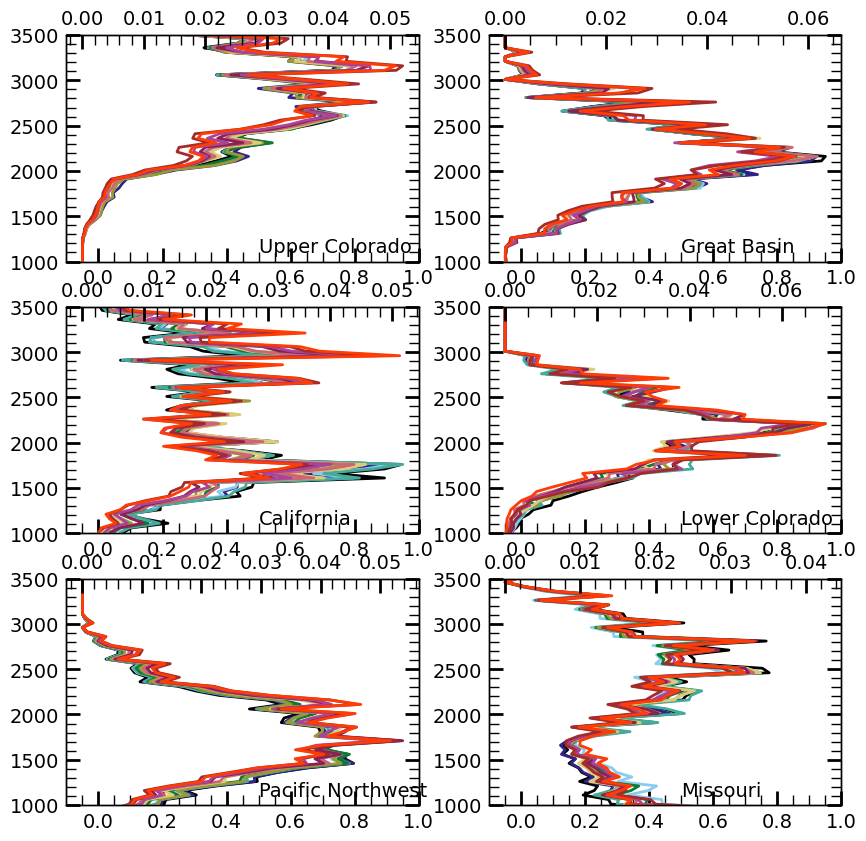

In [9]:
yrs = range(1980,2100, 10)
gcm = 4

fig,axs = plt.subplots(3,2, figsize = (10,10))
axs = axs.flatten()

for i, subregion in enumerate(subrnames):
    ax =axs[i]
    ax2 = ax.twiny()
    snowdata = snow_by_elev_bin[subregion][gcm]
    for j,data in enumerate(snowdata):
        ax2.plot(data / np.nansum(data), elevation_bins[1:], label = f'{yrs[i]}-{yrs[i]+10}', zorder=-1)
    ax.text(0.5,1100,subregion)
    ax.set_ylim((1000,3500))
    ax.set_xlim((-0.1,1.0))
plt.show()

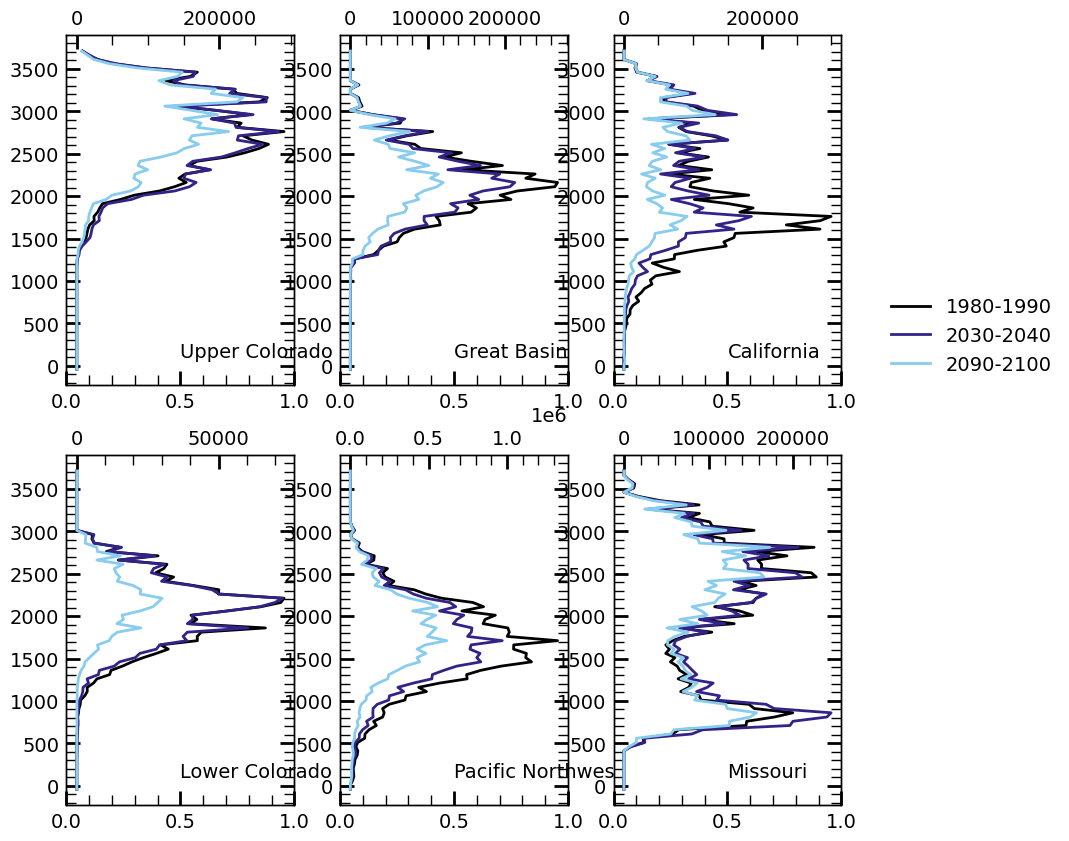

In [10]:
fig,axs = plt.subplots(2,3,figsize = (10,10))
axs = axs.flatten()
yrs = range(1980,2100, 10)

for i, subregion in enumerate(subrnames):
    ax = axs[i]
    ax2 = ax.twiny()
    snowdata = snow_by_elev_bin[subregion][gcm]
    for j,data in enumerate(snowdata):
         if j in[0,5,11]:
            ax2.plot(data, elevation_bins[1:], label = f'{yrs[j]}-{yrs[j]+10}', zorder=-1)
    ax.text(0.5,100,subregion)
ax2.legend(bbox_to_anchor = (2,1.5))
plt.show()

In [11]:
allcorrs = np.load(f'{basedir}/data/tmp/allcorrs_huc2.npy', allow_pickle = True).flatten()[0]

In [12]:
basinmap = {'eight': [0,8],
             'Upper Colorado': [1,9],
             'ten': [2,10],
             'Great Basin': [3,11],
             'California': [4,12],
             'Lower Colorado': [5,13],
             'Pacific Northwest': [6,15],
             'Missouri': [7,18]}


In [13]:
corr_recent_20 = np.zeros((8,9,101,20))
for basin in range(8):
    for gcm in range(9):
        for year in range(20,121):
            tmpdata = allcorrs[basin][gcm][year]
            corr_recent_20[basin,gcm,year-20,:] = tmpdata[-20:]


In [14]:
lat_snotel = []
lon_snotel = []
elev_snotel = []
lt10_idx = np.zeros((703,9)) ##ouput in snotel, gcm
goodlocs = []
for idx in range(703):
    ## indices of the snotel station
    j = jj[idx]
    i = ii[idx]
    ## 
    ## make sure to save lat, lon, and elev in the same order
    lat_snotel.append(lat_wrf[j,i].values.flatten()[0])
    lon_snotel.append(lon_wrf[j,i].values.flatten()[0])
    elev_snotel.append(elev_wrf[j,i].values.flatten()[0])
    ## 
    for gcm in range(9): # each gcm
        mydata = snotel_sweMax[idx,gcm,:] ## max swe at that snotel station  for all years
        mydata[0] = np.nan ## first year is 1980
        ## this is the algorithm
        ## 1) use an objective cutoff value
        # tmp = pd.DataFrame(mydata < 10, columns = ['lt10']) ## true/false is it less than [10] mm
        ## 2) use a percentile
        pct10 = np.nanpercentile(mydata[0:35], 10)
        tmp = pd.DataFrame(mydata < pct10, columns = ['lt10'])
        cutoff = (tmp.rolling(10).sum() > 5) ## when is the first date at which [50]% of the years are True # 
        
        ## if it never happens, make it above the range of the models
        if len(cutoff['lt10'][cutoff['lt10']]) == 0:
            firstyear = np.nan
            goodlocs.append(idx)
        ## otherwise, look at first index where it cutoff is true
        else:
            firstyear = cutoff.idxmax().values[0]
        lt10_idx[idx,gcm] = firstyear

/tmp/ipykernel_1515607/1746841204.py:10: RuntimeWarning: Mean of empty slice
  c_for_map = np.nanmean(lt10_idx, axis = 1) + 1981
/tmp/ipykernel_1515607/1746841204.py:28: RuntimeWarning: Mean of empty slice
  cbar = ax0.scatter(lon_snotel, lat_snotel, c= np.nanmean(lt10_idx,axis = 1) + 1981, cmap = years_cmap, s = 100)
/tmp/ipykernel_1515607/1746841204.py:36: RuntimeWarning: Mean of empty slice
  cbar = ax1.scatter(elev_snotel, lat_snotel, c= np.nanmean(lt10_idx,axis = 1) + 1981, cmap = years_cmap,s =150)


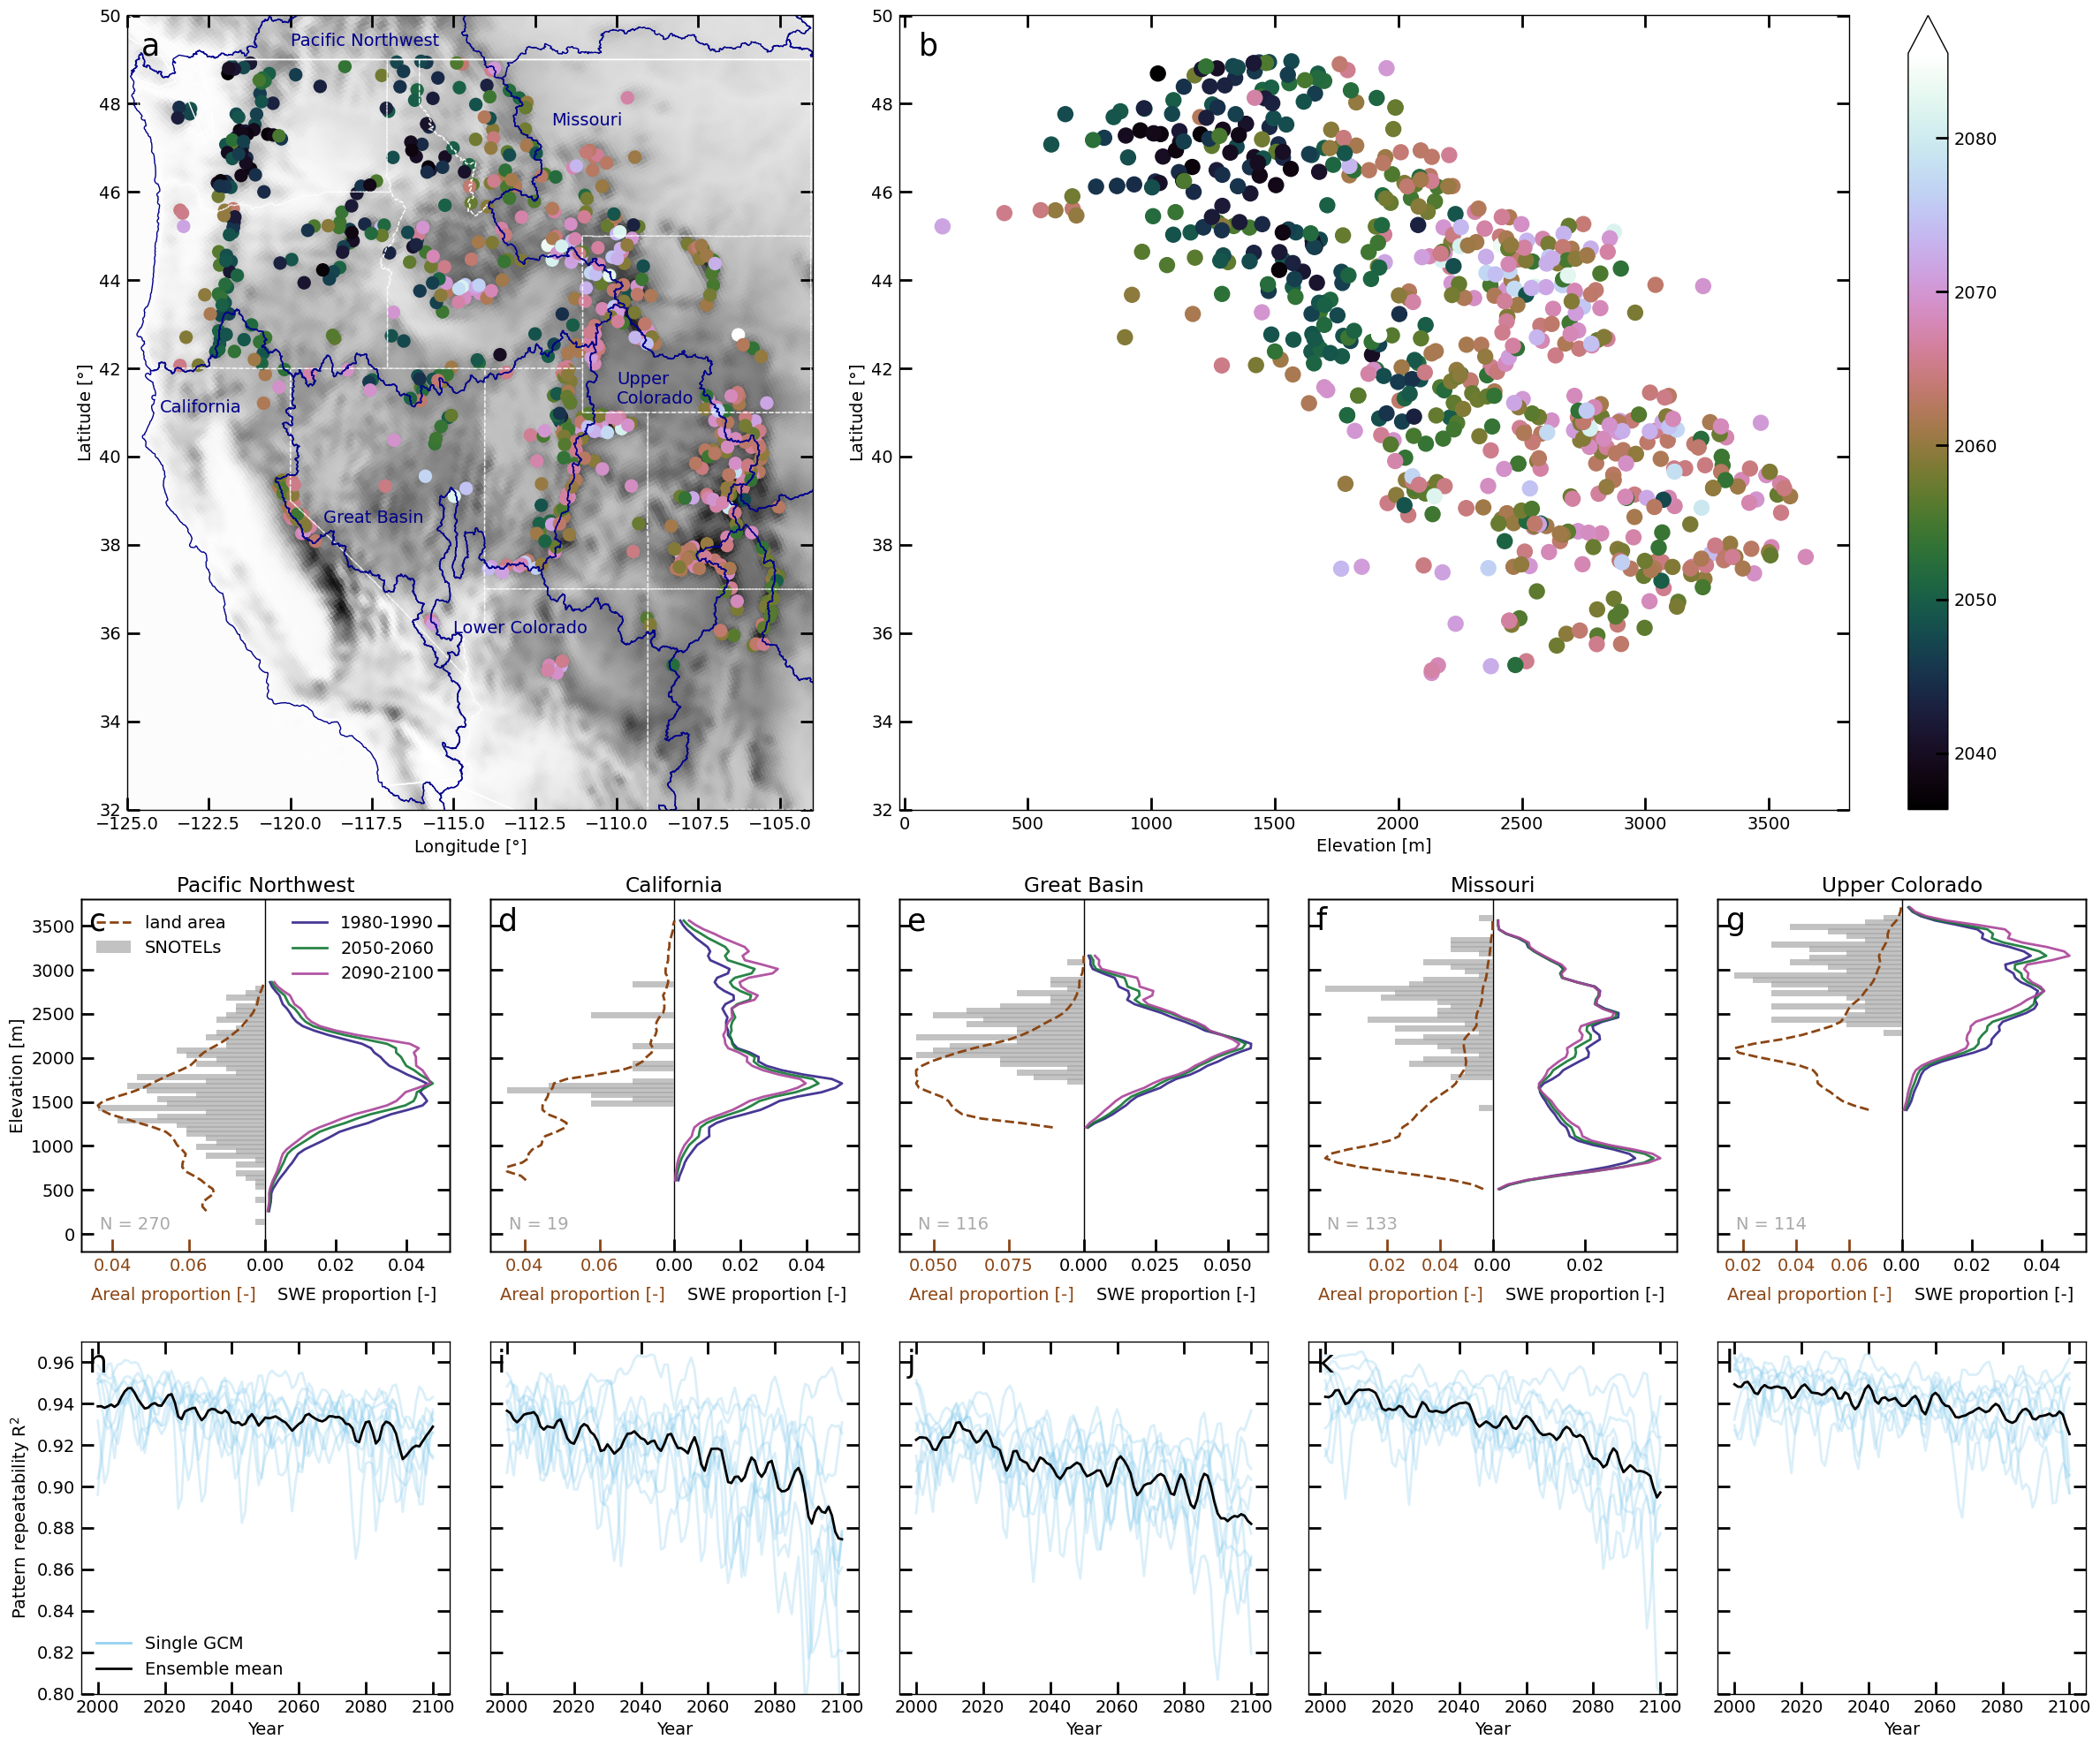

In [22]:

fig, axs = plt.subplot_mosaic([['A', 'A', 'B','B','B'],
                               ['A', 'A', 'B','B','B'],
                               ['c', 'd', 'e', 'f', 'g'],
                              ['h', 'i', 'j', 'k', 'l'],],
                             figsize = (24,20),
                              layout='tight')

letters = ['c','d','e','f','g','h','i','j','k','l']
basincolor = 'darkblue'
c_for_map = np.nanmean(lt10_idx, axis = 1) + 1981

basinlabels = [[-120,49.3,'Pacific Northwest'],
                [-110,41.2,'Upper\nColorado'],
               [-115,36,'Lower Colorado'],
               [-119,38.5,'Great Basin'],
               [-124,41,'California'],
               [-112,47.5,'Missouri']]

years_pattern = range(2000,2101)
import cmcrameri.cm as ccm
years_cmap = 'plasma_r' #'viridis_r'
years_cmap = ccm.batlow
years_cmap = 'cubehelix'
ax0 = axs['A']
ax0.pcolormesh(lon_wrf, lat_wrf, elev_wrf, cmap = cm.Greys)
world.boundary.plot(ax=ax0, color = 'white', linewidth =1 )
states.boundary.plot(ax=ax0, linewidth =1, color = 'white', alpha = 0.7, linestyle = '--')
cbar = ax0.scatter(lon_snotel, lat_snotel, c= np.nanmean(lt10_idx,axis = 1) + 1981, cmap = years_cmap, s = 100)
huc2.boundary.plot(ax=ax0, linewidth = 1, color = 'darkblue', label = 'Basin boundary')
ax0.set_xlim((-125,-104))
ax0.set_ylim((32,50))
ax0.set_xlabel('Longitude [$\degree$]')
ax0.set_ylabel('Latitude [$\degree$]')

ax1 = axs['B']
cbar = ax1.scatter(elev_snotel, lat_snotel, c= np.nanmean(lt10_idx,axis = 1) + 1981, cmap = years_cmap,s =150)
ax1.set_ylabel('Latitude [$\degree$]')
ax1.set_xlabel('Elevation [m]')
ax1.set_ylim((32,50))
plt.colorbar(cbar, extend = 'max')


for entry in basinlabels:
    ax0.text(entry[0], entry[1], entry[2], fontsize=14, color = basincolor)
    
for i, subregion in enumerate(subrnames2):
    ax_snotel =axs[letters[i]]
    ax_snow = ax_snotel.twiny()
    ax_area = ax_snow.twiny()
    ax_snotel.plot([0,0],[-300,5000],'k-', linewidth = 1)
    snowdata = smooth_snow_gcmmean_area[subregion]
    areadata = gaussian_filter1d(np.array(area_by_elev_bin[subregion]), sigma = 1)
    c = 0
    lim_snow = 0 
    for j,data in enumerate(snowdata):
        if j in[0,7,11]:
            if j == 0 :
                mask = data > 0.001
            ax_snow.plot(data[mask], elevation_bins[1:][mask], label=f'{yrs[j]}-{yrs[j]+10}', zorder=-1, color=yearcolors[c], alpha = 0.9)
            lim_snow = np.nanmax([lim_snow, np.nanmax(data[mask]) * 1.1])
            c+=1
        if j == 0:
            mysnotel= snotel_by_elev_bin[subregion]
            x_pos =  [(elevation_bins[i+1] + elevation_bins[i])/2 for i in range(len(elevation_bins)-1)]
            ax_snotel.barh(x_pos , -np.array(mysnotel) / np.nansum(mysnotel),height = 70,align='center', color='darkgray', alpha=0.7, zorder = 3, label = 'SNOTELs')
            ax_area.plot(-areadata[mask] / np.nansum(areadata[mask]),elevation_bins[1:][mask], color = 'saddlebrown',linestyle = '--', zorder = 2, label = 'land area')
    
    ax_snow.text(-lim_snow * 0.9,50, f'N = {np.nansum(mysnotel)}', color = 'darkgray')
    ax_snow.set_ylim((-200,3800))
    ax_snow.set_ylabel('Elevation [m]')
    ax_snotel.set_ylim((-200,3800))
    ax_area.set_ylim((-200,3800))
    lim_snotel =np.nanmax(np.array(mysnotel) / np.nansum(mysnotel)) * 1.1
    ax_snotel.set_xlim((-lim_snotel,lim_snotel))
    lim_area =np.nanmax(np.array(areadata[mask]) / np.nansum(areadata[mask])) * 1.1
    ax_snow.set_title(subregion)
    ax_pattern = axs[letters[i + 5]]
    to_mean = np.zeros((9,101))
    basinid = basinmap[subregion][0]
    for gcm in range(9):
        smoothed_outdata = gaussian_filter1d(np.nanmean(corr_recent_20[basinid,gcm,:,:], axis=1), sigma=1)  # Smoothing for outdata_recent_20
        ax_pattern.plot(years_pattern,smoothed_outdata, color='#88CCEE', alpha = 0.3)
        to_mean[gcm,:] = smoothed_outdata
    # ghost line for legend only
    ax_pattern.plot([0,0],[1,1], color='#88CCEE', alpha = 0.9, label = 'Single GCM')
    ax_pattern.plot(years_pattern,np.nanmean(to_mean, axis=0), label = 'Ensemble mean')
    ax_pattern.set_ylim((0.8,0.97))
    ax_pattern.set_xlim((1995,2105))

    ax_snotel.xaxis.set_ticks([])
    ax_pattern.set_xlabel('Year')
    
    ax_snow.set_xlim((-lim_snow,lim_snow))
    ax_area.set_xlim((-lim_area,lim_area))
       
    tick_positions = np.array(ax_snow.get_xticks())
    tick_labels = np.array( [tick.get_text().replace('−','-') for tick in ax_snow.get_xticklabels()])    
    new_tick_positions = tick_positions[tick_positions >= 0]
    new_tick_labels = tick_labels[tick_positions >=0]
     
    ax_snow.xaxis.set_label_position('bottom')
    ax_snow.set_xticks(new_tick_positions)
    ax_snow.set_xticklabels(new_tick_labels)
    ax_snow.set_xlabel('SWE proportion [-]', x=0.75, labelpad=10)
    
    area_labels = np.array([tick.get_text().replace('−','-') for tick in ax_area.get_xticklabels()])
    area_positions = np.array(ax_area.get_xticks())
    new_area_positions = tick_positions[tick_positions < 0]
    new_area_labels = tick_labels[tick_positions > 0]
    
    ax_area.xaxis.set_ticks_position('bottom')
    ax_area.xaxis.set_label_position('bottom')
    ax_area.tick_params(axis='x', colors='saddlebrown')

    ax_area.set_xticks(new_area_positions)
    ax_area.set_xticklabels(new_area_labels)
    ax_area.set_xlabel('Areal proportion [-]', color = 'saddlebrown',x=0.25, labelpad=10)
    
    ax_snow.set_xlim((-lim_snow,lim_snow))
    ax_area.set_xlim((-lim_area,lim_area))


    if i % 6 != 0:
        ax_snow.yaxis.set_ticklabels([])
        ax_pattern.yaxis.set_ticklabels([])
    if i % 6 == 0:
        ax_snotel.set_ylabel('Elevation [m]')
        ax_pattern.set_ylabel(r'Pattern repeatability R$^2$')
        ax_snow.legend(frameon = False, loc = 'upper right')
        ax_area.legend(loc = 'upper left')
        ax_snotel.legend(loc = 'upper left', bbox_to_anchor=(0, 0.93))
        ax_pattern.legend()

LETTERLABELS = True
def label_axis(axis, letter):
    axis.text(.02, .98, letter, ha='left', va='top', transform=axis.transAxes, fontsize = 25)
    return
axes = fig.axes[0:12]
for i,axis in enumerate(axes):
    label_axis(axis, chr(ord('`') + 1+ i))
    
fig.savefig(f'{basedir}/figures/fig2.png')

plt.show()
